In [12]:
import pandas as pd

### Pandas: merging by closest date example

In [13]:
left = pd.DataFrame({
    "ID": [1, 2, 3, 4, 5], 
    "date":[
        "06/22/2014",
        "07/02/2014",
        "01/01/2015",
        "01/01/1991",
        "08/02/1999"
    ]})

right = pd.DataFrame({
    "ID": [1, 2, 3, 4, 5, 6, 7], 
    "date":[
        "02/15/2015",
        "06/30/2014",
        "07/02/1999",
        "10/05/1990",
        "06/24/2014",
        "12/12/2222",
        "12/13/2222"
    ], "value": [333, 222, 444, 777, 42, 0, 0] 
})

left['date']  = pd.to_datetime(left.date)
right['date'] = pd.to_datetime(right.date)
left.sort_values('date', inplace=True)
right.sort_values('date', inplace=True)

# left, right

In [14]:
right1 = right.set_index('date').reindex(left.set_index('date').index, method='nearest').reset_index()

pd.merge(left, right1, on='date', suffixes=('_a', '_b'))

,ID_a,date,ID_b,value
0,4,1991-01-01,4,777
1,5,1999-08-02,3,444
2,1,2014-06-22,5,42
3,2,2014-07-02,2,222
4,3,2015-01-01,1,333


### Merging Engine data by closest time

In [15]:
egtm = pd.read_csv('./data/EGTM.csv', parse_dates=['RECORDED_DT'])

In [16]:
egtm_cols = egtm.columns[:5]
egtm = egtm[egtm_cols]
egtm = egtm[egtm['AIRCRAFT'] == 'VQ-BDQ']
egtm = egtm[egtm['POSITION'] == 1]
egtm['reportts'] = pd.to_datetime(egtm['RECORDED_DT'], format='mixed')
egtm['egtm_reportts'] = egtm['reportts']

In [17]:
neo = pd.read_csv(
    './data/a320_a321_neo_full_acms_parameters_202311140748.csv', 
    parse_dates=['reportts', 'processedts'], 
    low_memory=False
)
neo = neo[neo['acnum'] == 'VQ-BDQ']
neo = neo[neo['pos'] == 1]

ACMS = Aircraft Condition Monitoring System

In [18]:
neo.head()

,acnum,reportname,reportts,pos,fltdes,dep,arr,ivs12,ibe,iaie,...,vsva,w14,processedts,pf,wai,nai,prv,hpv,xf,reason
1,VQ-BDQ,A320 EEC MAINTENANCE REPORT,2021-06-09 17:46:56,1,5118.0,URKK,UNNT,NaN,NaN,NaN,...,0.0,NaN,2023-09-24 12:30:35.259,0.56,0.0,0.0,1.0,1.0,0.0,STW 16 BIT 27
4,VQ-BDQ,A320 EEC MAINTENANCE REPORT,2021-06-10 09:19:01,1,5142.0,URFF,UNNT,NaN,NaN,NaN,...,0.0,NaN,2023-09-24 12:30:36.899,0.56,0.0,0.0,1.0,1.0,0.0,STW 16 BIT 27
6,VQ-BDQ,A320 EEC MAINTENANCE REPORT,2021-06-10 09:23:38,1,0.0,URFF,UNNT,NaN,NaN,NaN,...,0.0,NaN,2023-09-24 12:30:37.285,0.46,0.0,0.0,0.0,0.0,0.0,STW 36 BIT 20
8,VQ-BDQ,A320 EEC MAINTENANCE REPORT,2021-06-10 15:29:58,1,5107.0,UNNT,URSS,NaN,NaN,NaN,...,0.0,NaN,2023-09-24 12:30:38.907,0.53,0.0,0.0,1.0,1.0,0.0,STW 16 BIT 27
11,VQ-BDQ,A320 EEC MAINTENANCE REPORT,2021-06-10 03:32:33,1,0.0,UNNT,URFF,NaN,NaN,NaN,...,0.0,NaN,2023-09-24 12:30:36.441,0.51,0.0,0.0,0.0,0.0,1.0,STW 36 BIT 20


#### Data frequency by time:

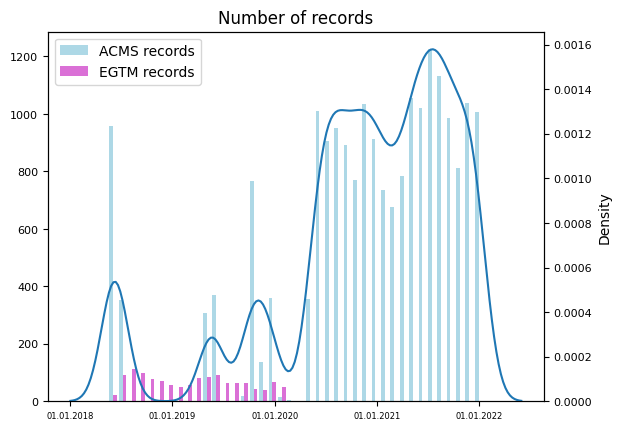

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

neo_report_timepoints = neo[neo['reportts'].dt.year < 2023 ]['reportts']
neo_report_timepoints = mdates.date2num(neo_report_timepoints)

plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=8)

fig, ax = plt.subplots()

ax2 = ax.twinx()

egtm_report_timepoints = egtm[egtm['reportts'].dt.year < 2023]['reportts']
egtm_report_timepoints = mdates.date2num(egtm_report_timepoints)

ax.hist([neo_report_timepoints, egtm_report_timepoints], bins=40, color=('lightblue', 'orchid'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))

sns.kdeplot(neo_report_timepoints, ax=ax2);
plt.title("Number of records")

ax.legend(['ACMS records', 'EGTM records'])

plt.show()

#### Merging with EGTM table by closest recorded date (using indexes)

In [20]:
neo.sort_values('reportts', inplace=True)
egtm.sort_values('reportts', inplace=True)

neo = neo.set_index('reportts')
egtm = egtm.set_index('reportts')

In [21]:
egtm1 = egtm.reindex(neo.index, method='ffill').reset_index()

In [22]:
merged = pd.merge(neo, egtm1, on='reportts')
merged.count()

reportts         20997
acnum            20997
reportname       20997
pos              20997
fltdes           20997
                 ...  
POSITION         20934
ESN              20934
RECORDED_DT      20934
RWCTOMAR         20934
egtm_reportts    20934
Length: 219, dtype: int64

In [23]:
merged['diff'] = (merged['reportts'] - merged['egtm_reportts']) \
  .astype('timedelta64[h]')

<Axes: title={'center': 'Time diff in hours'}, ylabel='Frequency'>

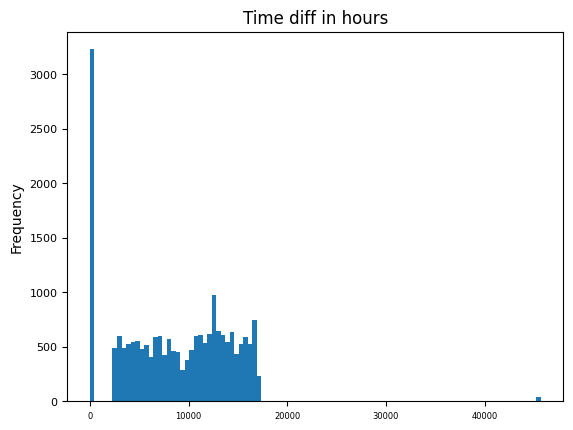

In [24]:
merged['diff'].plot.hist(bins=100, title='Time diff in hours')

<Axes: title={'center': 'Time diff in hours'}, ylabel='Frequency'>

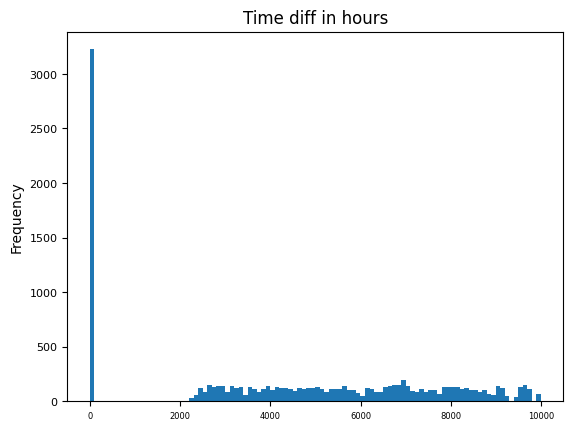

In [25]:
merged_filtered = merged[merged['diff'] <= 10_000]
merged_filtered['diff'].plot.hist(bins=100, title='Time diff in hours')

In [26]:
merged_filtered['diff'].count()

11541

<Axes: title={'center': 'Time diff in hours'}, ylabel='Frequency'>

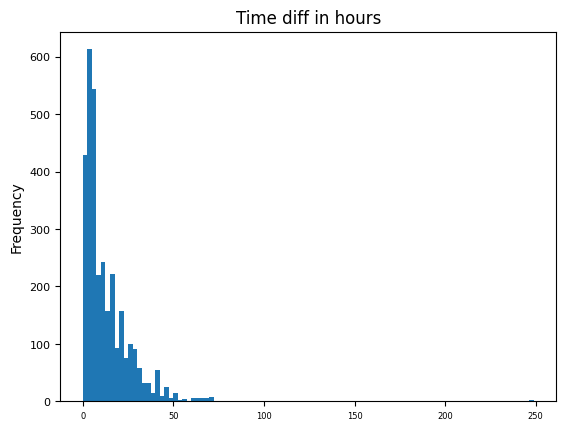

In [27]:
merged_filtered = merged[merged['diff'] <= 400]
merged_filtered['diff'].plot.hist(bins=100, title='Time diff in hours')

Вывод: Половине записей в таблице neo соответствует запись в egtm в окне +/- 400 часов

In [28]:
merged_filtered['diff'].count()

3229

### Эксперименты с частотой TAKEOFF

**TODO:**

1. Построить таблицу в рамках одного дня и построить количество данных слева и справа 
2. Отдельно для report name == TAKEOFF 
3. Сравнить частоту записей в рамках одного дня

In [29]:
egtm_line = egtm[
    (egtm['RECORDED_DT'].dt.year == 2019) & 
    (egtm['RECORDED_DT'].dt.month == 5)
].index
egtm.index

DatetimeIndex(['2018-05-20 19:36:47', '2018-05-22 01:48:50',
               '2018-05-23 19:51:23', '2018-05-25 01:07:05',
               '2018-05-26 10:41:08', '2018-05-27 23:01:23',
               '2018-05-29 08:05:07', '2018-05-30 08:31:49',
               '2018-05-31 14:07:19', '2018-06-01 22:12:10',
               ...
               '2020-01-29 04:45:27', '2020-01-29 16:36:17',
               '2020-01-30 12:31:39', '2020-01-30 22:41:42',
               '2020-01-31 08:38:30', '2020-01-31 14:36:22',
               '2020-02-01 14:42:58', '2020-02-02 04:14:45',
               '2020-02-02 16:24:00', '2020-02-02 22:24:23'],
              dtype='datetime64[ns]', name='reportts', length=1284, freq=None)

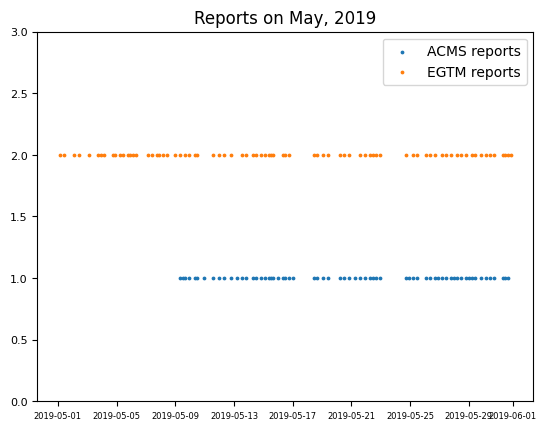

In [30]:
acms_line = neo[
    (pd.to_datetime(neo.index).year == 2019) & 
    (pd.to_datetime(neo.index).month == 5) & 
    (neo['reportname'] == 'A320 ENGINE TAKE OFF REPORT')
].index

egtm_line = egtm[
    (egtm['RECORDED_DT'].dt.year == 2019) & 
    (egtm['RECORDED_DT'].dt.month == 5)
].index

fig, ax = plt.subplots()

ax.scatter(acms_line, y=acms_line.map(lambda _ : 1), s=3)
ax.scatter(egtm_line, y=egtm_line.map(lambda _: 2), s=3)
ax.legend(["ACMS reports", "EGTM reports"])
ax.set_ylim([0, 3])
ax.set_title("Reports on May, 2019")
plt.show()

In [31]:
pd.DataFrame([egtm_line, acms_line]).T

,0,1
0,2019-05-01 03:32:02,2019-05-09 08:15:50
1,2019-05-01 09:36:22,2019-05-09 11:54:39
2,2019-05-02 03:00:31,2019-05-09 16:27:33
3,2019-05-02 10:22:17,2019-05-09 23:01:52
4,2019-05-03 03:40:28,2019-05-10 08:47:29
...,...,...
74,2019-05-30 16:37:27,NaT
75,2019-05-31 08:12:07,NaT
76,2019-05-31 11:53:59,NaT
77,2019-05-31 15:45:23,NaT


1. Строить по одной модели на каждый признак 
1. Более поздние на тест 
1. Модели: XGBoost, LinReg, RandomForest
1. Составить таблицу с результатами
1. Вначале взять только Takeoff
1. Затем попробовать Cruise
1. Метрика rmse 
1. Время не является признаком (только числовые фичи)
1. Самый важный параметр - EGTMARGIN
1. Проблемы автокореляции? 

Подготовить функции для построения графиков predict/target